# GEDI Cal/Val Field Data, Version 2

The MAAP includes data from the Unversity of Maryland's (UMD) GEDI CALIBRATION/VALIDATION (Cal/Val) Database.

> GEDI depends on world-wide, crowd-sourced in situ and airborne datasets to develop representative pre-launch calibration equations for predicting above ground biomass across the GEDI observation domain.

The MAAP enables users to query and visualize GEDI Cal/Val Field data via the `maap` python client.

This notebook demonstrates how to use the `maap` python client and the `folium` python mapping library to visualize plots from a given GEDI Cal/Val project on a map and then analyze trees from a given plot.

In [2]:
# The first time you run the notebook, you will need to install folium (and maap if not running in the MAAP ADE)
#!pip install folium
import folium
from maap.maap import MAAP
import matplotlib.pyplot as plt
import json
maap = MAAP()

In [3]:
collection  = {
  "Collection": {
      "ShortName": "GEDI Cal/Val Field Data_1",
      "VersionId": "2"
  }
}

`fetch_results` is a helper function for making queries to the `maap.executeQuery` service.

In [4]:
def fetch_results(query={}, timeout=180):
    """
    query the db for a bounding box and print the number of results and the first result
    """
    # use the executeQuery() function to get a response object
    response = maap.executeQuery(
      src = collection,
      query = query,
      poll_results = True,
      timeout = timeout
    )

    # if the 'Content-Type' is json, creates variable with json version of the response
    if (response.headers.get("Content-Type") == "application/json"):
        data = response.json()
    # if the 'Content-Type' is not json, creates variable with unicode content of the response
    else:
        data = response.text

    return json.loads(data)

# Create a list of 68 GEDI Cal/Val Field Data projects

During this MAAP release, the data system has updated the database to include an additional 44 projects which were added to the UMD database.

In [13]:
# Generate the list of projects dynamically
granules = maap.searchGranule(short_name='GEDI_CalVal_Field_Data', version='2', limit=200)
list_of_projects = list(set(['_'.join(granule['Granule']['GranuleUR'].split('_')[2:4]) for granule in granules]))
list_of_projects.sort()

In [14]:
print(list_of_projects)

['australia_ausplotsforests', 'australia_ilcp2015', 'australia_robsoncreek', 'canada_abovenwt', 'canada_saskatchewan', 'gabon_mondah', 'italy_sella', 'panama_bci', 'usa_bnzlter', 'usa_cafi', 'usa_cascadeeastzone', 'usa_cflra', 'usa_clearcreek', 'usa_damon', 'usa_dcef', 'usa_fernan', 'usa_fitsum', 'usa_michigan', 'usa_moscowmtn', 'usa_neonabby', 'usa_neonbart', 'usa_neonblan', 'usa_neonbona', 'usa_neonclbj', 'usa_neoncper', 'usa_neondeju', 'usa_neondela', 'usa_neondsny', 'usa_neongrsm', 'usa_neonguan', 'usa_neonharv', 'usa_neonheal', 'usa_neonjerc', 'usa_neonjorn', 'usa_neonkonz', 'usa_neonlaja', 'usa_neonleno', 'usa_neonmlbs', 'usa_neonmoab', 'usa_neonniwo', 'usa_neonnogp', 'usa_neononaq', 'usa_neonornl', 'usa_neonosbs', 'usa_neonpuum', 'usa_neonrmnp', 'usa_neonscbi', 'usa_neonserc', 'usa_neonsjer', 'usa_neonsoap', 'usa_neonsrer', 'usa_neonstei', 'usa_neontall', 'usa_neonteak', 'usa_neontree', 'usa_neonukfs', 'usa_neonunde', 'usa_neonwood', 'usa_neonwref', 'usa_neonyell', 'usa_pref', '

# Fetch plots for `australia_ausplotsforests` project

In order to visualize all the plots for a given project, we use the helper function to query the `plot` table.

In [15]:
project = 'australia_ausplotsforests'
results = fetch_results({
    "bbox": [-180, 90, 180, -90],
    "where": {
        "project": project
    },
    "fields": ["latitude", "longitude", "plot"],
    "table":"plot"
}, 1000)

Plots are represented more than once, so we generate a dictionary to get the unique set of plots for mapping purposes.

In [16]:
project_plots = {}
keys = [ 'latitude', 'longitude' ]
for result in results:
    project_plots[result['plot']] = { key: result[key] for key in keys }

In [17]:
# Select the first plot, just to center the map easily
first_plot = list(project_plots.keys())[2]
first_plot

'NSFNNC004'

In [18]:
center = [ project_plots[first_plot]['latitude'], project_plots[first_plot]['longitude'] ]
# Note, depending on which project you are querying,
# the start zoom could be much higher (more zoomed in)
zoom = 3
m = folium.Map(location=center, tiles="Stamen Terrain", zoom_start = zoom)
 
# Add marker one by one on the map
for plot in project_plots.items():
    folium.Marker(
        [plot[1]['latitude'], plot[1]['longitude']],
        popup = f"plot: {plot[0]}"
    ).add_to(m)

m

# Plot trees for first plot of this project

In [19]:
results = fetch_results({
    "bbox": [-180, 90, 180, -90],
    "where": {
        "project": project,
        "plot": first_plot
    },
    # total height of plant from ground to highest leaf
    "fields": [ "h.t", "x", "y", "z"],
    "table": "tree"
}, 1000)
# results

In [20]:
print(f"Number of trees: {len(results)}")
heights = [r["h.t"] for r in results if r["h.t"] is not None]
print(f"Number of trees with heights: {len(heights)}")

hts = [r['h.t'] for r in results] 
xs = [r['x'] for r in results]
ys = [r['y'] for r in results]

Number of trees: 526
Number of trees with heights: 93


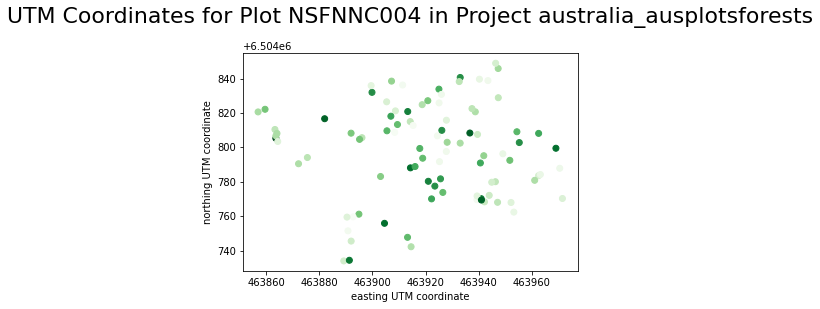

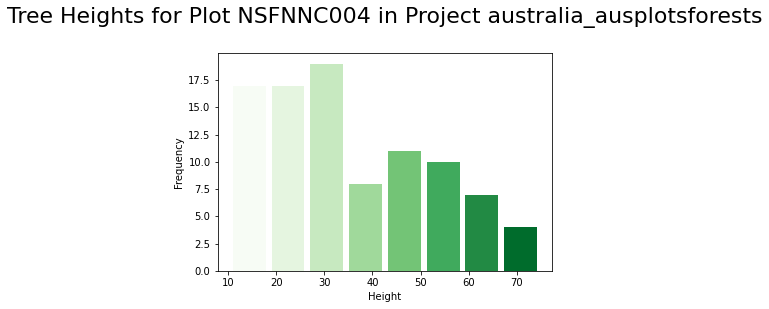

In [47]:
plt.scatter(xs, ys, c=hts, cmap="Greens")
plt.xlabel('easting UTM coordinate')
plt.ylabel('northing UTM coordinate')
plt.title(f"UTM Coordinates for Plot {first_plot} in Project {project}\n", fontsize=22)
plt.show()

cm = plt.cm.Greens
nbins = 8
n, bins, patches = plt.hist(x=heights, bins=nbins, rwidth=0.85)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/nbins))
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title(f"Tree Heights for Plot {first_plot} in Project {project}\n", fontsize=22)
plt.show()